# Data Cleaning & EDA

### Data Cleaning Steps/ Goals:

1. Read in various dataframes and append into 1 dataframe
2. Drop duplicated values
3. Handle missing values (missing text)
4. Handle links & short 'posts'
5. Countvectorize (text & title?- combine both or keep separate?) 
6. Examine trends (average word-count, sentiment analysis etc)
7. Store dataframe without vectorized columns


In [126]:
# Imports:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


### Combining datasets and Dropping Duplicates

In [127]:
# Read in ultralight data
u1 = pd.read_csv('data/Ultralight/ultralight.csv')
u2 = pd.read_csv('data/Ultralight/ultralight1.csv')
u3 = pd.read_csv('data/Ultralight/ultralight2.csv')
u4 = pd.read_csv('data/Ultralight/ultralight3.csv')
u5 = pd.read_csv('data/Ultralight/ultralight4.csv')


In [128]:
#Combine into 1 ultralight dataset
datasets = [u1, u2, u3, u4, u5]
ultralight = pd.concat(datasets)

In [129]:
ultralight.shape

(9445, 5)

In [130]:
ultralight.nunique()

Unnamed: 0     3974
created_utc    2001
title          1996
self_text      2584
subreddit         1
dtype: int64

In [131]:
ultralight.duplicated().sum()

7

In [132]:
# Drop any duplicate posts
ultralight.drop_duplicates(inplace=True)

In [133]:
ultralight.shape

(9438, 5)

In [134]:
# Read in all camping datasets
c1 = pd.read_csv('data/Camping/camping.csv')
c2 = pd.read_csv('data/Camping/camping1.csv')
c3 = pd.read_csv('data/Camping/camping2.csv')
c4 = pd.read_csv('data/Camping/camping3.csv')
c5 = pd.read_csv('data/Camping/camping4.csv')

In [135]:
cdatasets= [c1, c2, c3, c4]

In [136]:
# Combine into 1 camping datarame
camping = pd.concat(cdatasets)

In [137]:
camping.shape

(8609, 5)

In [138]:
camping.nunique()

Unnamed: 0     3832
created_utc    2862
title          2851
self_text      1610
subreddit         1
dtype: int64

In [139]:
camping.duplicated().sum()

1319

In [140]:
#Drop any duplicated posts from camping
camping.drop_duplicates(inplace=True)

In [141]:
camping.shape

(7290, 5)

In [142]:
camping.duplicated().sum()

0

In [143]:
camping.isna().sum()

Unnamed: 0        0
created_utc       0
title             0
self_text      3285
subreddit         0
dtype: int64

In [145]:
ultralight.isna().sum()

Unnamed: 0       0
created_utc      0
title            0
self_text      459
subreddit        0
dtype: int64

### Handling Missing Values

Since all the missing values in my dataframe are empty self-text and self-text is what the model will be trained on, all missing values in the dataframe can be dropped completely.

In [144]:
# Dropping missing from camping
camping.dropna(inplace=True)

In [146]:
# Dropping missing values from ultralight
ultralight.dropna(inplace=True)

In [147]:
ultralight.shape

(8979, 5)

In [148]:
camping.shape

(4005, 5)

### Combining the two subreddits into 1 dataframe 

In [149]:
#Combining ultralight and camping into 1 dataframe
combined = [camping, ultralight]
df = pd.concat(combined)

In [150]:
#Binarize Subreddit column with ultralight = 1 and camping = 0
df['subreddit'] = df['subreddit'].replace({'Ultralight': 1, 'camping': 0})
df.subreddit.value_counts()

1    8979
0    4005
Name: subreddit, dtype: int64

In [151]:
df.shape

(12984, 5)

### Double-checking dataframe for any lingering issues

In [154]:
df.isna().sum()

Unnamed: 0     0
created_utc    0
title          0
self_text      0
subreddit      0
dtype: int64

In [155]:
df.dtypes

Unnamed: 0       int64
created_utc    float64
title           object
self_text       object
subreddit        int64
dtype: object

### Dropping unecessary Unnamed column

In [ ]:
df.drop(columns=['Unnamed: 0']

# Exploratory Data Analysis

Goals:
1. Learn more about the differences between the two subreddits
    - post length
    - top words
    - average sentiment
2. Examine any trends that may be helpful for modeling
3. Identify any patterns or trends that may create difficulties for modeling
4. 

In [156]:
#Use a lambda function to create a word count column
df['word_count'] = df['self_text'].apply(lambda x: len(str(x).split()))

#How many rows do I have where self-text is at least 10 words long?
count_greater_than_10 = len(df[df['word_count'] > 10])
count_greater_than_10 = (df['word_count'] > 10).sum()
print("Number of rows with more than 10 words in 'self_text':", count_greater_than_10)

Number of rows with more than 10 words in 'self_text': 12702


In [157]:
df.head()

,Unnamed: 0,created_utc,title,self_text,subreddit,word_count
1,1,1.697501e+09,Car camping recommendations in the GA/NC/TN area?,Hi there! Looking for solid car camping recomm...,0,30
2,2,1.697499e+09,"Oceano Dunes, CA",Annual trip with friends & family. Always an e...,0,10
3,3,1.697498e+09,"Fort pickens, Fl",Picks from this past weekend. Would recommend ...,0,10
4,4,1.697498e+09,Camping groups,"Are there camping groups out there, that someo...",0,276
5,5,1.697497e+09,Camping in North Carolina,Where do you like to camp in NC? Is there any ...,0,14


### Sentiment Analysis

How does the average sentiment of each subreddit differ if at all?

In [158]:
# Instantiate Sentiment Intensity Analyzer
sa = SentimentIntensityAnalyzer()

df['self_text'].fillna('', inplace=True)

# Apply sentiment analysis to each row in the DataFrame
df['sentiment'] = df['self_text'].apply(lambda x: sa.polarity_scores(x))

In [159]:
df['vader_score'] = df['self_text'].apply(lambda x: sa.polarity_scores(x)['compound'])

In [160]:
df.head()

,Unnamed: 0,created_utc,title,self_text,subreddit,word_count,sentiment,vader_score
1,1,1.697501e+09,Car camping recommendations in the GA/NC/TN area?,Hi there! Looking for solid car camping recomm...,0,30,"{'neg': 0.0, 'neu': 0.935, 'pos': 0.065, 'comp...",0.2244
2,2,1.697499e+09,"Oceano Dunes, CA",Annual trip with friends & family. Always an e...,0,10,"{'neg': 0.0, 'neu': 0.721, 'pos': 0.279, 'comp...",0.4767
3,3,1.697498e+09,"Fort pickens, Fl",Picks from this past weekend. Would recommend ...,0,10,"{'neg': 0.0, 'neu': 0.576, 'pos': 0.424, 'comp...",0.7096
4,4,1.697498e+09,Camping groups,"Are there camping groups out there, that someo...",0,276,"{'neg': 0.07, 'neu': 0.855, 'pos': 0.075, 'com...",0.3604
5,5,1.697497e+09,Camping in North Carolina,Where do you like to camp in NC? Is there any ...,0,14,"{'neg': 0.0, 'neu': 0.599, 'pos': 0.401, 'comp...",0.8105


In [161]:
#Createa a column for the word count of the title
df['word_count_title'] = df['title'].apply(lambda x: len(str(x).split()))

In [162]:
#Save a dataset with all missing values dropped
df.to_csv('data/combined_dataset_no_missings.csv')

Is a post with less than 10 words valuable to train the model? I will save 1 dataframe with only the empty/ missing posts dropped and another dataframe with any short posts (defined as less than 10 words long) dropped.

In [163]:
#Save a dataset with all 'short' statuses dropped
df = df[df['word_count'] >= 10]
df.to_csv('data/combined_dataset_no_short_posts.csv')

In [164]:
df.groupby('subreddit')['word_count', 'vader_score', 'word_count_title'].mean()

C:\Users\kaitl\AppData\Local\Temp\ipykernel_14448\3777903337.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby('subreddit')['word_count', 'vader_score', 'word_count_title'].mean()


,word_count,vader_score,word_count_title
subreddit,,,
0,92.477362,0.490590,6.861293
1,281.466950,0.627803,7.989581


# Data Observations

1. Posts in the Ultralight subreddit are more positive on average than posts in the camping subreddit 
2. Posts in the Ultralight subreddit are longer than posts in the camping subreddit


#### Implication for Machine Learning:

1. The model will be trained on a larger quantity of 'ultralight' vs 'camping' language which could lead to bias
2. The culture of the subreddits may be different and not indicative of the larger populations- everyone who is an ultralight backpacker and everyone who camps. The significant difference in sentiment can be due to differences in moderation between the subreddits, rules for posting etc. 

In [165]:
ultra = df[df['subreddit']==1]

In [166]:
# Using a CountVectorizer for EDA

X = ultra['self_text']
y = ultra['subreddit']

cvec = CountVectorizer(stop_words='english')
X = cvec.fit_transform(X)
X.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [167]:
cvec.get_feature_names_out()

array(['00', '000', '0001', ..., 'östgötaleden', 'оnе', 'расk'],
      dtype=object)

In [168]:
X_df = pd.DataFrame(X.todense(), columns = cvec.get_feature_names_out())

In [169]:
X_df.shape

(8926, 27012)

In [170]:
len(df[df['subreddit']==1])

8926

<Axes: >

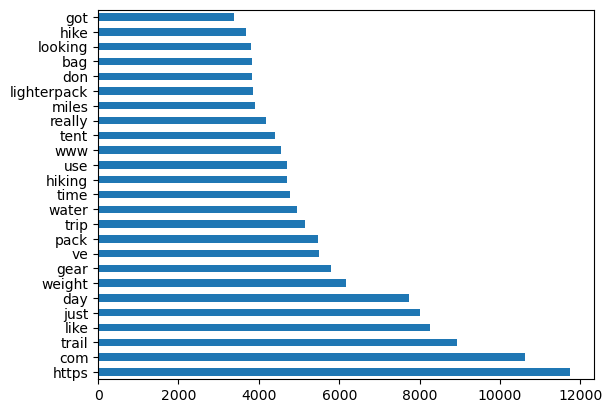

In [171]:
# plot top 25 words for each subreddit
X_df.sum().sort_values(ascending=False).head(25).plot(kind='barh')

In [172]:
# Do I need to remove statuses with links? Or can I just remove the links from the statuses?
# Would there be any benefit from leaving them in?

In [173]:
camp=df[df['subreddit']==0]

In [174]:
#Do I want to add pre-processing to my count-vectorizer such as lemmatizer or tokenizer?

X = camp['self_text']
y = camp['subreddit']

cvec = CountVectorizer(stop_words='english')
X = cvec.fit_transform(X)
X.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [175]:
X_df = pd.DataFrame(X.todense(), columns = cvec.get_feature_names_out())

<Axes: >

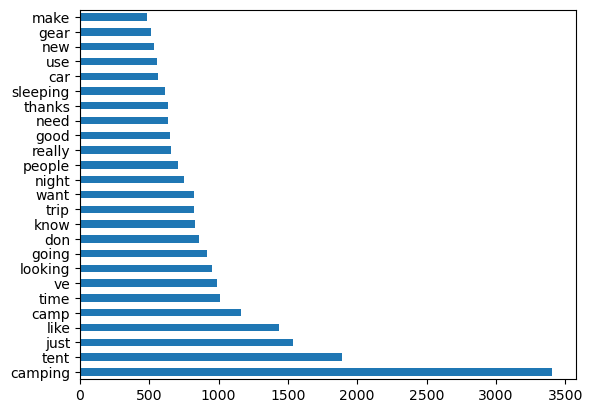

In [176]:
# plot top 25 words for each subreddit
X_df.sum().sort_values(ascending=False).head(25).plot(kind='barh')

When examining the top 25 words from each subreddit, as expected there is some overlap between the two. Words such as tent, gear, trip, and time appear frequently in posts in both subreddits. Some of the biggest differences seem to be the frequency of words such as camp and camping vs hike and hiking. I expect that while there will be considerable overlap (in that most words used in one subreddit will also be used in the other) the frequencies of some words will vary greatly. 